In [1]:
## Intalling Preliminaries

!pip install pygame
import numpy as np
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame as pg
import random
from google.colab.patches import cv2_imshow
from google.colab import output

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Obstacle:
  def __init__(self,corner, dims):
      self.corner = corner
      self.dims = dims
      self.rect = pg.Rect(self.corner,self.dims)
      self.points = np.zeros((4,2))
      self.calc_dims()

  def calc_dims(self):
      self.points[0,:] = np.asarray(self.corner)
      self.points[1,:] = np.asarray((self.corner[0]*self.dims[0],self.corner[1]))
      self.points[2,:] = np.asarray((self.corner[0]*self.dims[0],self.corner[1]*self.dims[1]))
      self.points[3,:] = np.asarray((self.corner[0],self.corner[1]*self.dims[1]))

  def isIntersecting(self,parent,child):
      if self.rect.clipline((child.x,child.y),(parent.x,parent.y)):
          return True
      else:
          return False



In [50]:

class MapGenerator:
  def __init__(self, width = 540, height = 540, start = (20,40), goal = (400,300)):
    self.mapDim = (width, height)
    self.width = width
    self.height = height
    self.goal = goal
    self.start = start


    pg.init()
    pg.display.set_caption('RRT path planning')
    self.map = pg.display.set_mode(self.mapDim)
    self.map.fill((255,255,255))

    self.ORANGE = (32,100,255) #BGR
    self.RED = (32,60,201)#(201,60,32)
    self.BLACK = (0,0,0)
    self.GREEN = (68,171,27)
    self.WHITE = (255,255,255)
    self.GRAY = (92, 94, 92)
    self.YELLOW = (52, 158, 235) #(3, 252, 223)

    self.MAX_OBSTACLE_SIZE = 100
    self.MIN_OBSTACLE_SIZE = 50
    self.NUM_OBSTACLES = 10
    self.obstacles = []

  def drawSample(self,p1,p2):
    # print("here")
    pg.draw.circle(self.map, self.ORANGE,(p1,p2),0,2)

  def connectNodes(self, n1,n2):
    pg.draw.line(self.map, self.BLACK, n1,n2)

  def connectFinalPath(self, colour, n1, n2):
    if(colour is None):
      colour = self.GREEN
    pg.draw.line(self.map, colour, n1,n2, width=3)

  def collisonFree(self,rect):
    if(not self.obstacles):
      return True
    else:
      for obstacle in self.obstacles:
          if rect.colliderect(obstacle.rect): # in-built Pygame function
              return False
      return True

  def generateObstacleDimension(self):
    obstacleDimX = random.randint(self.MIN_OBSTACLE_SIZE,self.MAX_OBSTACLE_SIZE)
    obstacleDimY = random.randint(self.MIN_OBSTACLE_SIZE,self.MAX_OBSTACLE_SIZE)
    upper_x = random.randint(0,self.width-obstacleDimX)
    upper_y = random.randint(0,self.height-obstacleDimY)
    return [obstacleDimX,obstacleDimY,upper_x,upper_y]

  def showMap(self):
    image = pg.surfarray.array3d(self.map)
    image = image.transpose([1, 0, 2])
    output.clear(wait=True)
    cv2_imshow(image)

  def draw_start_end(self):
    pg.draw.circle(self.map, self.GREEN, self.start, 7, 0)
    pg.draw.circle(self.map, self.RED, self.goal, 7, 0)

  def draw_obstacle(self):
    for obstacle in self.obstacles:
        pg.draw.rect(self.map,self.BLACK,obstacle.rect)

  def generateObstacle(self):
    for i in range(self.NUM_OBSTACLES):
      # print(i)
      valid = False
      while(not valid):
        obs_dim = self.generateObstacleDimension()
        # print(obs_dim)
        rect = pg.Rect((obs_dim[2],obs_dim[3]), (obs_dim[0],obs_dim[1]))
        if(not rect.collidepoint(self.start) and not rect.collidepoint(self.goal) and self.collisonFree(rect)):
            valid = True
      self.obstacles.append(Obstacle( (obs_dim[2],obs_dim[3]), (obs_dim[0],obs_dim[1]) ))
      # print(self.obstacles)

  def generate_map(self):
        self.generateObstacle()
        self.draw_obstacle()
        self.draw_start_end()
        self.showMap()


In [4]:
class Node:
  def __init__(self, id, x, y):
    self.x = x
    self.y = y
    self.id = id
    self.parent = None
    self.array = np.asarray((x,y)).reshape(1,-1)
    self.cost = 0
    self.optimFlag = False
    self.vis = float('inf')


In [5]:
class Graph:
  def __init__(self, startPos, goal):
    self.start = Node(0,startPos[0], startPos[1])
    self.goal = Node(-1, goal[0], goal[1])
    self.vertices = []
    self.edges = {}
    self.pointsArray = []


    self.start.cost = 0
    self.vertices = [self.start]
    self.edges = {self.start.id:[]}
    self.pointsArray = np.asarray(startPos).reshape(-1,2)

  def addNode(self, n1, n2):
    n2.id = len(self.vertices)
    # print(n1.id)
    # print("n2.id", n2.id)
    n2.parent = n1.id
    dist = np.linalg.norm(n2.array - n1.array)
    n2.cost = n1.cost + dist
    self.vertices.append(n2)
    nodeAsArray = np.asarray((n2.x, n2.y)).reshape(-1,2)
    self.pointsArray = np.append(self.pointsArray, nodeAsArray, axis = 0)

    if(n1.id in self.edges):
      self.edges[n1.id].append(n2.id)
    else:
      self.edges[n1.id] = [n2.id]



In [54]:
class RRT():
  def __init__(self, map, graph):
    self.stepSize = 10
    self.map = map
    self.graph = graph
    self.currSample = None
    self.parent = None
    self.sampleRandom()
    self.finalCost = 0

  def sampleRandom(self):
    x = int(random.uniform(0,self.map.width))
    y = int(random.uniform(0, self.map.height))
    self.currSample = Node(-2, x, y)

  def getPointFromRandomSample(self):
    vector = self.currSample.array - self.parent.array
    unitVector = vector / np.linalg.norm(vector)
    point = self.parent.array + unitVector*self.stepSize
    return Node(-2, point[0,0], point[0,1])

  def findNearest(self):
    dist = np.linalg.norm(self.graph.pointsArray - self.currSample.array, axis = 1).reshape(-1,1)
    nearestNodeid = np.argmin(dist)
    nearestDist = dist[nearestNodeid]
    # print(self.graph.vertices[nearestNodeid])
    return self.graph.vertices[nearestNodeid], nearestDist

  def isObstacleFree(self):
    for obs in self.map.obstacles:
      if(obs.rect.collidepoint((self.currSample.x,self.currSample.y))):
          return False
      else:
          if(obs.isIntersecting(self.parent,self.currSample)):
           return False
    return True

  def checkCollision(self):
    self.parent, dist = self.findNearest()
    if(dist > self.stepSize):
      self.currSample = self.getPointFromRandomSample()
      dist = self.stepSize

    if(self.isObstacleFree()):
      return self.currSample
    else:
      return None

  def is_Goal_Reached(self):
    if np.linalg.norm(self.currSample.array-self.graph.goal.array) < 10:
        return True
    else:
        return False

  def backTrack(self):
    curr = self.currSample
    while(curr.id != 0):
      self.finalCost += curr.cost
      parent = self.graph.vertices[curr.parent]
      self.map.connectFinalPath(None, (parent.x, parent.y), (curr.x, curr.y))
      curr = parent

  def rrt(self):
    i = 0
    while(not self.is_Goal_Reached()):
      i += 1
      self.sampleRandom()

      while(self.checkCollision() is None): # sample until a point in free space is found
        self.sampleRandom()
      # print(self.parent)
      # print("here1")
      self.graph.addNode(self.parent, self.currSample)
      self.map.drawSample(self.currSample.x, self.currSample.y)
      self.map.connectNodes((self.parent.x, self.parent.y), (self.currSample.x, self.currSample.y))
      if(i // 2 == 0):
        self.map.showMap()

    self.graph.addNode(self.parent, self.currSample) # To add last point to the Graph
    self.backTrack()
    self.map.showMap()
    print(self.finalCost)

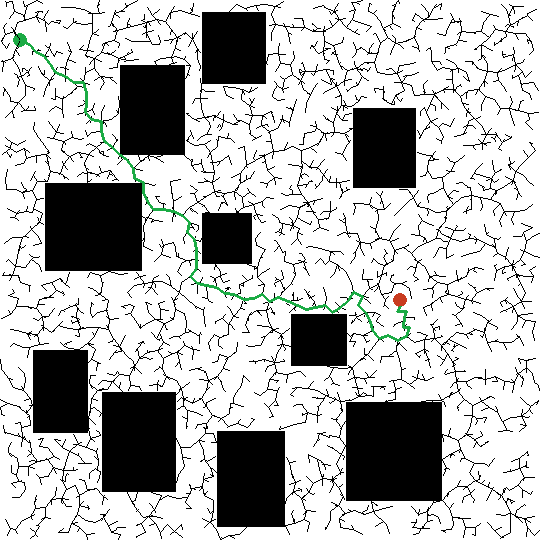

23423.597035476607


In [55]:
## RRT

start = (20,40)
goal = (400,300)
map = MapGenerator(start=start,goal=goal)
map.generate_map()
MAP = map.map.copy()
graph1 = Graph(start,goal)
rrt = RRT(map,graph1)
rrt.rrt()

In [62]:
class RRTStar(RRT):
  def __init__(self, map, graph):
    super().__init__(map,graph)
    # self.colour = colour
    self.rewireRadius = 10
    self.finalCost = 0
    self.endNode = None

  def backtractRRTStar(self, colour):
    curr = self.endNode
    while(curr.id != 0):
      curr.optimFlag = True
      self.finalCost += curr.cost
      parent = self.graph.vertices[curr.parent]
      self.map.connectFinalPath(colour, (parent.x,parent.y), (curr.x, curr.y))
      curr = parent

  def rewire(self):
    currCost = self.parent.cost + np.linalg.norm(self.parent.array - self.currSample.array)
    dist = np.linalg.norm(self.graph.pointsArray - self.currSample.array, axis = 1).reshape(-1,)
    flag = False

    for i in range(dist.shape[0]):
      if(dist[i] <= self.rewireRadius):
        newParent = self.graph.vertices[i]
        newCost = newParent.cost + np.linalg.norm(newParent.array - self.currSample.array)
        if(newCost < currCost and self.newObstacleFree(newParent)):
          if(self.parent.optimFlag == True):
            flag = True
            self.parent.optimFlag = False
            newParent.optimFlag = True

          self.parent = newParent
          currCost = newCost

    self.graph.addNode(self.parent, self.currSample)

    if(flag):
      if(self.is_Goal_Reached()):
        self.endNode = self.currSample
      self.backtractRRTStar(self.map.YELLOW)
      self.map.showMap()

  def newObstacleFree(self,new_parent):
    for obs in self.map.obstacles:
        if obs.isIntersecting(new_parent,self.currSample):
            return False
    return True

  def rrtStar(self):
    i = 0
    while(not self.is_Goal_Reached()):
      i += 1
      self.sampleRandom()

      while(self.checkCollision() is None):
        self.sampleRandom()

      self.rewire()
      # self.graph.addNode(self.parent, self.currSample)
      self.map.drawSample(self.currSample.x, self.currSample.y)
      self.map.connectNodes((self.parent.x, self.parent.y), (self.currSample.x, self.currSample.y))
      if(i % 20 == 0):
        self.map.showMap()

    self.graph.addNode(self.parent, self.currSample)
    self.endNode = self.currSample
    self.backtractRRTStar(self.map.YELLOW)
    self.map.showMap()
    print(self.finalCost)


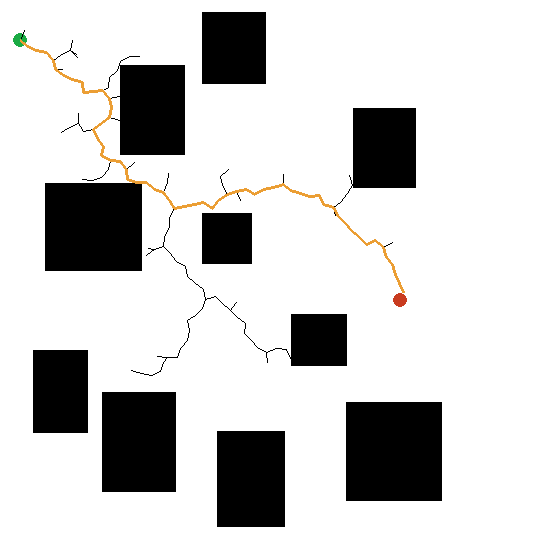

17700.0


In [63]:
## RRT STAR
map.map = MAP.copy()
graph2 = Graph(start,goal)
rrt_star = RRTStar(map,graph2)
rrt_star.rrtStar()